# Hybrid-MC: DICOM Data

Hybrid Monte Carlo (MC) SPECT reconstruction. uses SIMIND as a backend. See the website https://simind.blogg.lu.se/exempelsida/ for instructions on how to install, and how to cite their work. Once `simind` has been set as a path variable on your system (one of their install instructions), then you should be able to run the code of this tutorial.

Hybrid MC SPECT reconstruction replaces conventional forward projection $\bar{y} =H \hat{x}$ with an MC prediction $\bar{y}_{\text{MC}} = \hat{H}_{\text{MC}}\hat{x}$. In practice, the term $\hat{H}_{\text{MC}}\hat{x}$ is estimated all at once via simulation of many individual photons; $\hat{H}_{\text{MC}}$ is given a hat because it is effectively estimated using random variables. Unlike conventional reconstruction $\hat{H}_{\text{MC}}$ estimates the contribution from all photons, so a scatter correction term is not required.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import itk
import numpy as np
from torch.nn.functional import avg_pool3d
import pytomography
from pytomography.io.SPECT import simind, dicom
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap, subsample_projections
from pytomography.projectors.SPECT import MonteCarloHybridSPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import MonteCarloHybridSPECTPoissonLogLikelihood
from pytomography.utils import simind_mc
sys.path.append('./src')

In [2]:
path = '/ac225listmode/pytomography_tutorial_data/SPECT'

First we'll load the data from the introductory DICOM tutorial. We additioanlly create an attenuation map at 140 keV since this will be required for the MC forward projections.

* The attenuation and PSF transform are used in the analytical back projection

In [3]:
file_NM = os.path.join(path, 'Lu177-NEMA-SymT2', 'projection_data.dcm')
path_CT = os.path.join(path, 'Lu177-NEMA-SymT2', 'CT')
files_CT = [os.path.join(path_CT, f) for f in os.listdir(path_CT)] 
# 140 keV map is needed for MC forward projector
amap140 = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, E_SPECT=140.5)
# 208keV is needed for analytical back projection
amap208 = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, E_SPECT=208)
projections = dicom.get_projections(file_NM)
object_meta, proj_meta = dicom.get_metadata(file_NM)
att_transform = SPECTAttenuationTransform(amap208)
collimator_name = 'SY-ME'
energy_kev = 208 #keV
intrinsic_resolution=0.38 #mm
psf_meta = dicom.get_psfmeta_from_scanner_params(
    collimator_name,
    energy_kev,
    intrinsic_resolution=intrinsic_resolution
)
psf_transform = SPECTPSFTransform(psf_meta)

Given photopeak energy 140.5 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 140.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2
Given photopeak energy 208 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


The first thing we need in the MC simulation is the energy window parameters from the projection data. This creates a list similar to a scattwin.win file in SIMIND

In [4]:
energy_window_params = simind_mc.get_energy_window_params_dicom(file_NM) 
energy_window_params

['187.19999694824,228.80000305176,0',
 '166.39999389648,187.19999694824,0',
 '228.80000305176,249.60000610352,0',
 '101.69999694824,124.30000305176,0',
 '85.879997253418,101.69999694824,0',
 '124.30000305176,146.89999389648,0']

Now we specify the isotope and detector information that we'll need to feed into our reconstruction
* This needs to be carefully configured for different isotopes

In [5]:
isotope_names = ['lu177'] # isotope we want to simulate
isotope_ratios = [1] # ratio of isotopes (in this case only 1)
collimator_type = 'SY-ME' # collimator type to use
cover_thickness = 0.1 # cover thickness in cm (aluminum assumed)
backscatter_thickness = 6.6 # backscatter thickness in cm (pyrex)
advanced_energy_resolution_model='siemens' 
# if the energy resolution model above is not used, then
# the energy resolution needs to be provided at 140keV in
# units of percent.
energy_resolution_140keV = 10 # %
crystal_thickness = 0.9525 # thickness in crystal in cm (NaI)

We also need to choose the number of photons to simulate per projection, as well as the number of parallel CPU jobs to run. I find the 200 million photons per projection works reasonably well for most isotopes. Since I have a powerful computer, I use 90 CPU cores in parallel to run projection (if you have the option, you should select a computer with more CPU power as opposed to GPU power since SIMIND only runs on CPU).
* Change `n_parallel` to how many CPU cores your system has, most have around 8-16.

In [ ]:
# this takes around 20min to run with 90 CPU cores
n_events = 200e6
n_parallel = 90

Now we'll build the hybrid system matrix, which performs MC forward projection and analytical back projection

In [ ]:
system_matrix = MonteCarloHybridSPECTSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms=[att_transform, psf_transform],
    proj2proj_transforms=[],
    attenuation_map_140keV=amap140,
    energy_window_params=energy_window_params,
    primary_window_idx=0, # based on the 208keV window from energy_window_params
    isotope_names=isotope_names,
    isotope_ratios=isotope_ratios,
    collimator_type=collimator_type,
    crystal_thickness=crystal_thickness,
    cover_thickness=cover_thickness,
    backscatter_thickness=backscatter_thickness,
    advanced_energy_resolution_model=advanced_energy_resolution_model,
    advanced_collimator_modeling=True,
    n_events=n_events,
    n_parallel=n_parallel
)

likelihood = MonteCarloHybridSPECTPoissonLogLikelihood(system_matrix, projections[0])
algorithm = OSEM(likelihood)
recon_MC = algorithm(n_iters=1, n_subsets=16)

Plot an axial slice of the reconstructed image:

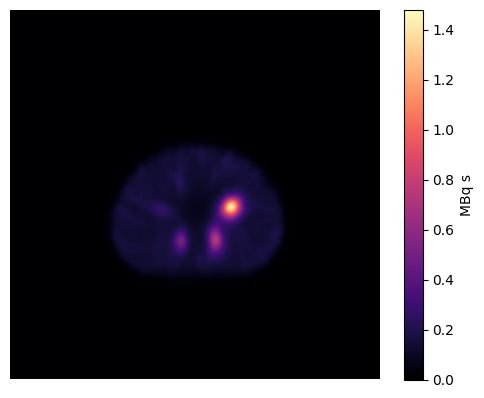

In [8]:
plt.imshow(recon_MC[:,:,60].cpu().T, cmap='magma',interpolation='gaussian')
plt.axis('off')
plt.colorbar(label='MBq s')

It should be noted that the predicted units of the reconstructed image are MBq s (need to divide by the time per projection to get units of MBq). Because of this, point source-based calibration will not work to obtain quantitative units (since the units are already quantitative).

However, there may be discrepancies between the simulated scanner and a real scanner. For this reason, the best way to calibrate is to reconstruct a cylindrical phantom with known activity, segment the cylinder using a 130% boundary (approximately) and then derive a correction factor that puts the MC MBq units to real MBq units (for example, the sensitivity of a real scanner might be 10% lower so a necessary "calibration factor" in this case would be 1.1)